In [209]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import argparse
from utils import read_data


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.test_ratio = 0.2
args.seed = 123
args.nbits = 2048
args.kernel = 'rbf'
args.C = 1.0
args.gamma = 'auto'
args.n_splits = 5


np.random.seed(args.seed)
list_tox_type = ['nr-ahr', 'nr-ar-lbd', 
                 'nr-ar', 'nr-aromatase', 
                 'nr-er-lbd', 'nr-er', 
                 'nr-ppar-gamma', 'sr-are', 
                 'sr-atad5', 'sr-hse', 
                 'sr-mmp', 'sr-p53']


# Prepare Dataset

In [203]:
# Generate bit vector from given smile string
def get_fingerprint(smile, args):
    mol = Chem.MolFromSmiles(smile)
    fingerprint = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=args.nbits)
    bit_string = fingerprint.ToBitString()
    bit_vec = np.array([int(bit) for bit in bit_string])
    return bit_vec
    
# Generate Dataset by shuffling, fingerprinting, spliting
def make_dataset(args, tox_type='nr-ahr'):
    smiles, label = read_data(tox_type)
    smiles, label = shuffle(smiles, label, random_state=args.seed)
    
    # Convert Smiles to Morgan Fingerprints and exclude failure cases
    list_vec = list()
    list_label = list()
    for i, smile in enumerate(smiles):
        try:
            vec = get_fingerprint(smile, args)
            list_vec.append(vec)
            list_label.append(label[i])
        except:
            pass
        
    """
    # Split Train Set and Test Set
    X_dummy, X_test, y_dummy, y_test = train_test_split(list_vec, list_label, 
                                                        test_size=args.test_ratio, 
                                                        random_state=args.seed)
    # Use some portion of the train set
    X_train, X_dummy, y_train, y_dummy = train_test_split(X_dummy, y_dummy,
                                                         test_size=1-args.data_ratio,
                                                         random_state=args.seed)
    """
    return np.array(list_vec), np.array(list_label)

# Training and Evaluating Model

In [204]:
def train(train_x, train_y, model, args):
    model.fit(train_x, train_y)
    return model

def evaluate(test_x, test_y, model, args):
    proba_y = model.predict_proba(test_x)  
    roc_auc = roc_auc_score(test_y, proba_y[:, 1])
    fpr, tpr, _ = roc_curve(test_y, proba_y[:, 1])
    
    predict_y = model.predict(test_x)
    accu = accuracy_score(test_y, predict_y)
    return accu, roc_auc, fpr, tpr

# Visualizing ROC Curve

Reference : http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [205]:
def plot_roc(roc_auc, fpr, tpr, accu):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.3f}) (accu = {:0.3f})'.format(roc_auc, accu))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Experiment Template

In [206]:
def experiment(x_train, y_train, x_test, y_test, args):
    model = SVC(C=args.C, kernel=args.kernel, gamma=args.gamma, verbose=False, probability=True)
    model = train(x_train, y_train, model, args)
    accu, roc_auc, fpr, tpr = evaluate(x_test, y_test, model, args)
    return accu, roc_auc, fpr, tpr

In [211]:
def kfold_experiment(X, y, args):
    cv = StratifiedKFold(n_splits=args.n_splits)
    
    list_accu = list()
    list_roc_auc = list()
    for train_index, test_index in cv.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        accu, roc_auc, fpr, tpr = experiment(x_train, y_train, x_test, y_test, args)
        list_accu.append(accu)
        list_roc_auc.append(roc_auc)
    
    return np.array(list_accu).mean(), np.array(list_roc_auc).mean()

# Experiemnt1. roc_auc vs nbits

In this experiment, roc_auc would be calculated with different nbits values. If the value of the nbits is too low, then fingerprint vector would not represent important information. Otherwise, if the value of the nbits is too high, then fingerprint vector would be sparse so that model would less capture important feature from the fingerprint vector

In [214]:
%%time
args.data_ratio = 1.0
list_nbits = [1, 2,4,8,16] #[32, 64, 128, 256, 512, 1024, 2048]
list_experiments = list()
for nbits in list_nbits:
    args.nbits = nbits
    X, y = make_dataset(args)
    mean_accu, mean_roc_auc = kfold_experiment(X, y, args)
    print("Exp. {} bits. Mean Accu: {:0.3f} Mean ROC_AUC: {:0.3f}".format(nbits, mean_accu, mean_roc_auc))
    result = {"nbits":nbits, "roc_auc":roc_auc, "fpr":fpr, "tpr":tpr, "accu":accu}
    list_experiments.append(result)

Exp. 1 bits. Mean Accu: 0.881 Mean ROC_AUC: 0.500
Exp. 2 bits. Mean Accu: 0.886 Mean ROC_AUC: 0.499
Exp. 4 bits. Mean Accu: 0.889 Mean ROC_AUC: 0.508
Exp. 8 bits. Mean Accu: 0.887 Mean ROC_AUC: 0.549
Exp. 16 bits. Mean Accu: 0.889 Mean ROC_AUC: 0.713
CPU times: user 43.7 s, sys: 15.6 ms, total: 43.7 s
Wall time: 43.7 s


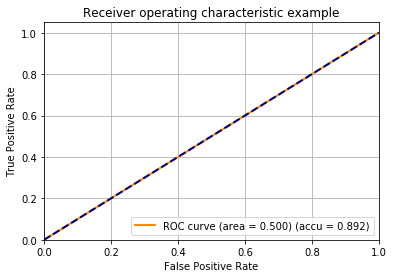

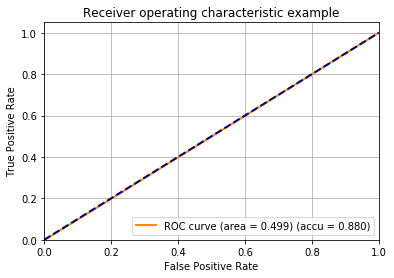

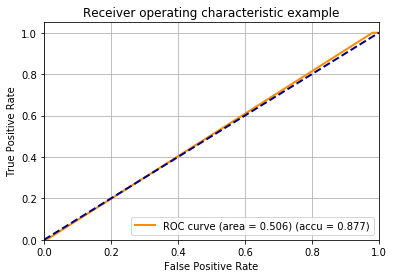

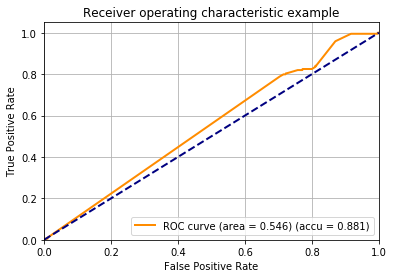

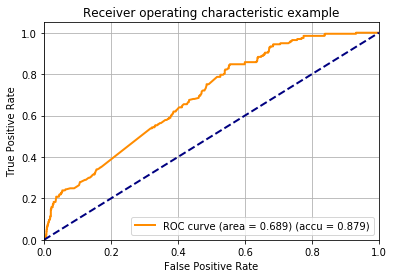

In [182]:
for result in list_experiments:
    plot_roc(result['roc_auc'], result['fpr'], result['tpr'], result['accu'])

In [165]:
a = 0.6545
print('{:0.3f}'.format(a))

0.654


CPU times: user 671 ms, sys: 8 µs, total: 671 ms
Wall time: 670 ms


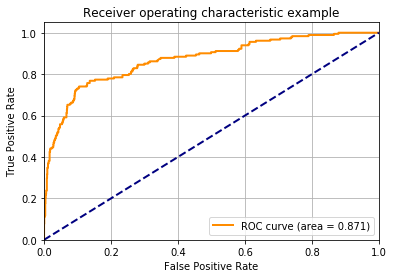

In [76]:
plot_roc(roc_auc, fpr, tpr)